In [1]:
# Load libraries
import pandas as pd
from pandas.plotting import scatter_matrix
from matplotlib import pyplot

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

In [2]:
#load candidate dataset
path = "/home/nachshon/Documents/Genetics/candidate.csv"
dataset = pd.read_csv(path)

In [3]:
# shape
print(dataset.shape)

(1895, 22)


In [4]:
print(dataset.head(5))

    group  Any_PTSD_LT  PPsecondENDER  SUM_NUMBER_OF_LIFETIME_TRAUMAS  \
0  second            0              1                               1   
1  second            0              1                               6   
2  second            0              1                               3   
3  second            0              2                               3   
4  second            0              1                               2   

   child_abuse  trauma_dichotomous  SOCIAL_SUPPORT_SUM  MDD     PC1     PC2  \
0            0                   0                  20    0 -0.0081 -0.0036   
1            0                   1                  14    1 -0.0065 -0.0025   
2            0                   0                  22    1 -0.0076 -0.0033   
3            0                   0                  15    0 -0.0084 -0.0037   
4            0                   0                  16    0 -0.0085 -0.0029   

   ...     PC5     PC6     PC7     PC8     PC9    PC10  rs1049353  rs12720071  \
0  ..

In [5]:
# descriptions
print(dataset.describe())

       Any_PTSD_LT  PPsecondENDER  SUM_NUMBER_OF_LIFETIME_TRAUMAS  \
count  1895.000000    1895.000000                     1895.000000   
mean      0.070712       1.093931                        3.701847   
std       0.256411       0.291810                        2.431592   
min       0.000000       1.000000                        1.000000   
25%       0.000000       1.000000                        2.000000   
50%       0.000000       1.000000                        3.000000   
75%       0.000000       1.000000                        5.000000   
max       1.000000       2.000000                       14.000000   

       child_abuse  trauma_dichotomous  SOCIAL_SUPPORT_SUM          MDD  \
count  1895.000000         1895.000000         1895.000000  1895.000000   
mean      0.024802            0.437467           19.443799     0.160422   
std       0.155563            0.496205            4.950961     0.367094   
min       0.000000            0.000000            0.000000     0.000000   
25%

In [6]:
# class distribution - PTSD undersample
print(dataset.groupby(['group','Any_PTSD_LT']).size())

group   Any_PTSD_LT
VA      0              1290
        1                96
second  0               471
        1                38
dtype: int64


In [7]:
# seperate gentic factors vs behvioural factors for plotting
beh = dataset.iloc[:,1:8]
gen = dataset.iloc[:,18:]
subset = pd.concat([beh, gen],axis=1, sort=False) 

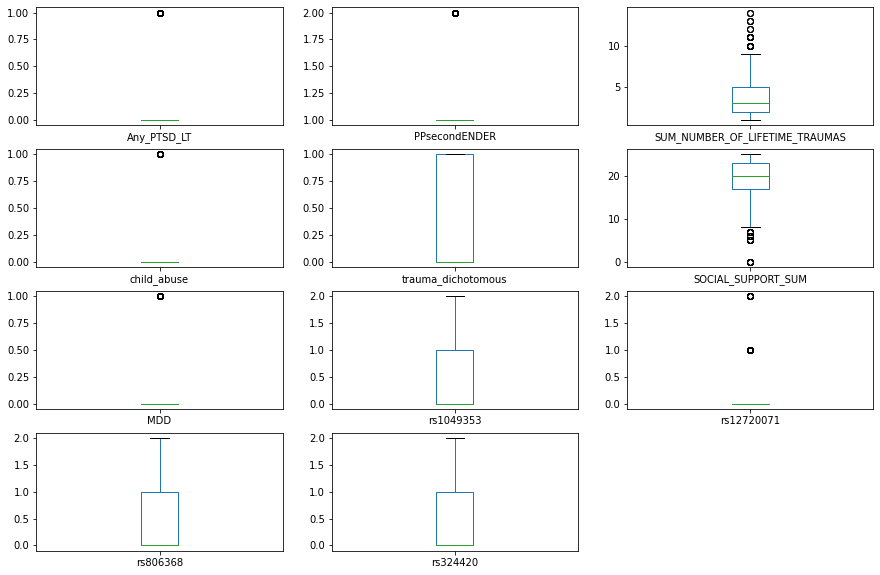

In [8]:
# box and whisker plots - doesn't look promising
subset.plot(kind='box', subplots=True, layout = (4,3), figsize=(15,10), sharex=False, sharey=False)
pyplot.show()

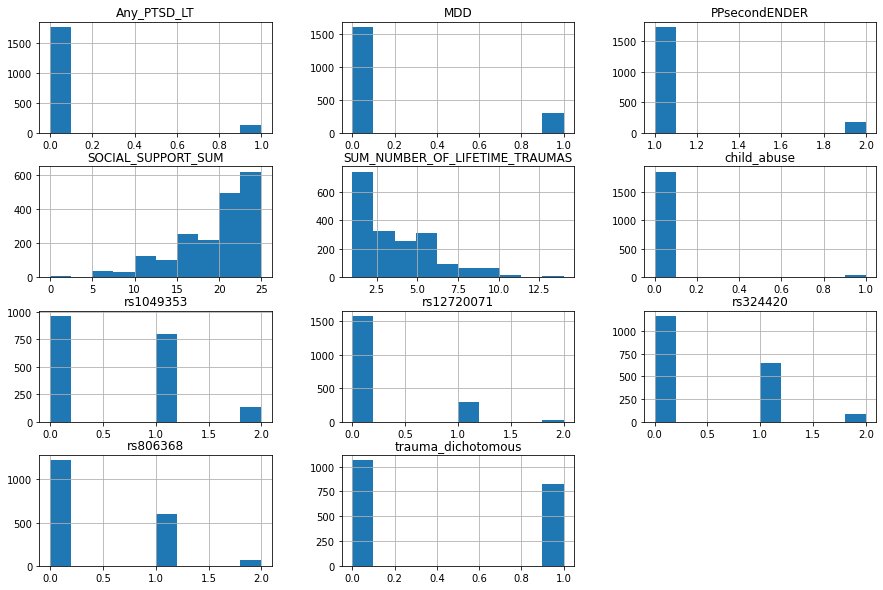

In [9]:
# histograms - looks a bit better
subset.hist(figsize=(15,10))
pyplot.show()

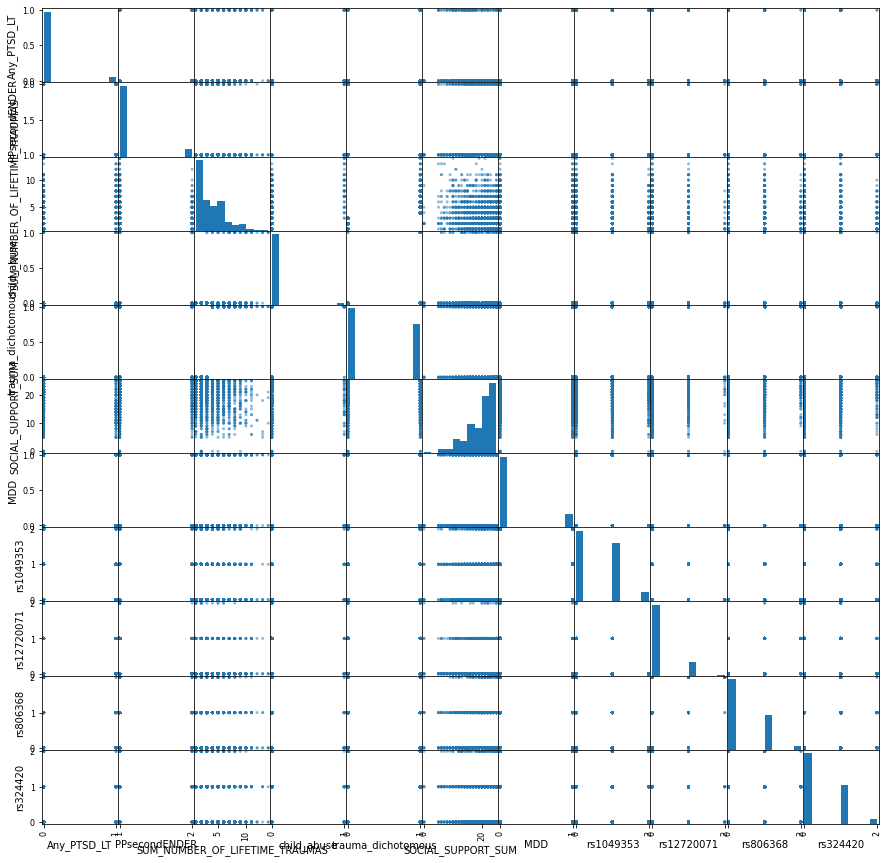

In [10]:
#scatter plot matrix - a mess 
scatter_matrix(subset, figsize=(15,15))
pyplot.show()

In [11]:
# subset the two cohort. The big cohort ('V') will be used to build and test the algoritm and tone hyper
# parameters. Final test will be on the second cohort ('G')

evaluate = dataset[dataset['group']=='VA']
pred = dataset[dataset['group']=='second']

X = evaluate.iloc[:,2:]
y = evaluate.iloc[:,1]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

pred_X = pred.iloc[:,2:]
pred_y = pred.iloc[:,1]

# In order to test the contribuation of the behavioural factors and genetics, they were divided into 2 seperate
# databases.

beh = evaluate.iloc[:,1:8]
gen = pd.concat([evaluate.iloc[:,1], evaluate.iloc[:,8:]],axis=1, sort=False) 

Xb = beh.iloc[:,1:]
yb = beh.iloc[:,0]

Xg = gen.iloc[:,1:]
yg = gen.iloc[:,0]

Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb, yb, test_size=0.3, random_state=1)
Xg_train, Xg_test, yg_train, yg_test = train_test_split(Xg, yg, test_size=0.3, random_state=1)

In [12]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('wLR', LogisticRegression(solver='liblinear', multi_class='ovr',class_weight={1: 10})))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
models.append(('wSVM', SVC(gamma='auto', class_weight={1: 10})))
#models.append(('GB', GradientBoostingClassifier(n_estimators=1000)))
models.append(('ADB', AdaBoostClassifier(n_estimators=1000)))

In [15]:
# evaluate genetics data - looks very bad... persion 0
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Recall = cross_val_score(model, Xg_train, yg_train, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, Xg_train, yg_train, cv=kfold, scoring='f1')
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s: Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR: Recall: 0.000000 (0.000000); f1: 0.000000 (0.000000)
LDA: Recall: 0.000000 (0.000000); f1: 0.000000 (0.000000)
wLR: Recall: 0.132143 (0.102020); f1: 0.094956 (0.088632)
KNN: Recall: 0.000000 (0.000000); f1: 0.000000 (0.000000)
CART: Recall: 0.137500 (0.124245); f1: 0.084146 (0.084036)
NB: Recall: 0.078571 (0.085341); f1: 0.066100 (0.067928)
SVM: Recall: 0.000000 (0.000000); f1: 0.000000 (0.000000)
wSVM: Recall: 0.026786 (0.053720); f1: 0.018831 (0.043506)
ADB: Recall: 0.000000 (0.000000); f1: 0.000000 (0.000000)


In [16]:
#over sample genetics
from imblearn.over_sampling import SMOTE
import numpy as np

sm = SMOTE(random_state=12)
xg_train_res, yg_train_res = sm.fit_sample(Xg_train, yg_train)

In [17]:
# evaluate genetics with over sampling - KNN seems to look good
Percision = []
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Percision = cross_val_score(model, xg_train_res, yg_train_res, cv=kfold, scoring='precision')
    cv_Recall = cross_val_score(model, xg_train_res, yg_train_res, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, xg_train_res, yg_train_res, cv=kfold, scoring='f1')
    Percision.append(cv_Percision)
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s: Percision: %f (%f); Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Percision.mean(), cv_Percision.std(),
           cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR: Percision: 0.526438 (0.045538); Recall: 0.518464 (0.034512); f1: 0.522007 (0.037580)
LDA: Percision: 0.572264 (0.036711); Recall: 0.629176 (0.057565); f1: 0.598948 (0.044390)
wLR: Percision: 0.500000 (0.002793); Recall: 1.000000 (0.000000); f1: 0.666662 (0.002483)
KNN: Percision: 0.706114 (0.025933); Recall: 0.964270 (0.022258); f1: 0.815139 (0.024111)
CART: Percision: 0.811752 (0.046069); Recall: 0.855843 (0.043513); f1: 0.835922 (0.032326)
NB: Percision: 0.566907 (0.016549); Recall: 0.926280 (0.029083); f1: 0.703177 (0.018054)
SVM: Percision: 0.538428 (0.015726); Recall: 0.921835 (0.031803); f1: 0.679578 (0.017470)
wSVM: Percision: 0.500000 (0.002793); Recall: 1.000000 (0.000000); f1: 0.666662 (0.002483)
ADB: Percision: 0.884690 (0.023585); Recall: 0.869288 (0.013999); f1: 0.876713 (0.013963)


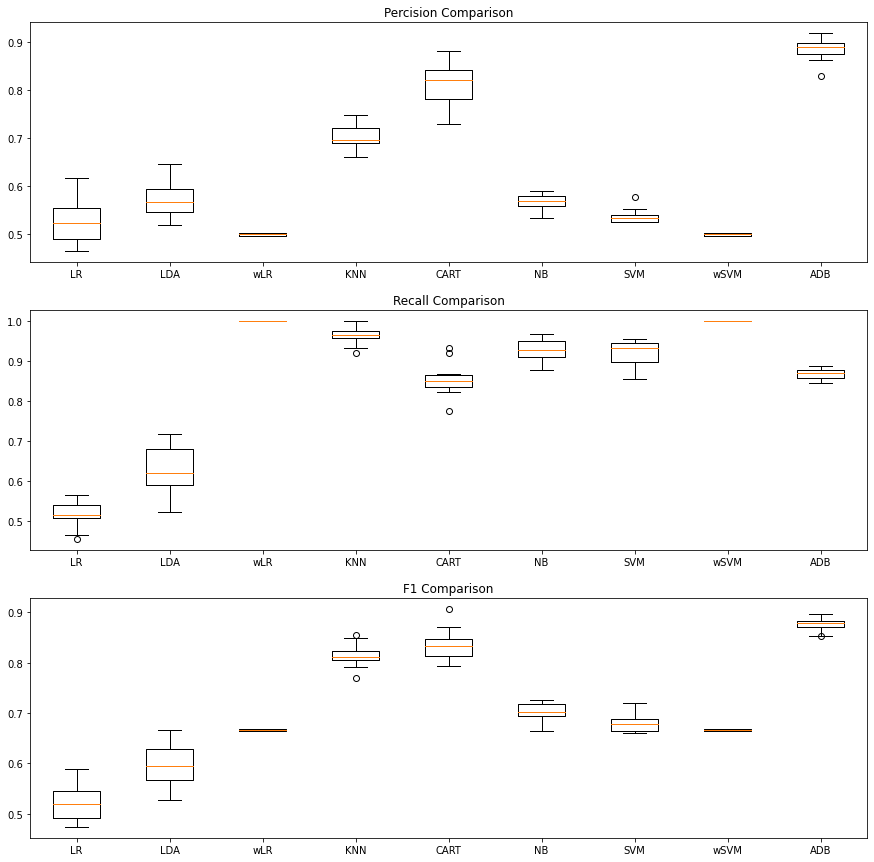

In [18]:
# plot genetics models predictability 
f = pyplot.figure(figsize=(15,15))
f.add_subplot(3, 1, 1)
pyplot.boxplot(Percision, labels=names)
pyplot.title('Percision Comparison')
f.add_subplot(3, 1, 2)
pyplot.boxplot(Recall, labels=names)
pyplot.title('Recall Comparison')
f.add_subplot(3, 1, 3)
pyplot.boxplot(F1, labels=names)
pyplot.title('F1 Comparison')
pyplot.show(block=True)

In [21]:
# Make predictions on validation dataset
model =  DecisionTreeClassifier()
model.fit(xg_train_res, yg_train_res)
predictions = model.predict(Xg_test)

# Evaluate predictions genetics
print(accuracy_score(yg_test, predictions))
print(confusion_matrix(yg_test, predictions))
print(classification_report(yg_test, predictions))

0.7524038461538461
[[306  89]
 [ 14   7]]
              precision    recall  f1-score   support

           0       0.96      0.77      0.86       395
           1       0.07      0.33      0.12        21

    accuracy                           0.75       416
   macro avg       0.51      0.55      0.49       416
weighted avg       0.91      0.75      0.82       416



In [22]:
# evaluate behaviour - percision equal 0
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Recall = cross_val_score(model, Xb_train, yb_train, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, Xb_train, yb_train, cv=kfold, scoring='f1')
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s:Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR:Recall: 0.323214 (0.161002); f1: 0.415618 (0.194739)
LDA:Recall: 0.523214 (0.206719); f1: 0.522429 (0.177290)
wLR:Recall: 0.757143 (0.188171); f1: 0.447178 (0.105595)
KNN:Recall: 0.128571 (0.148074); f1: 0.186768 (0.211679)
CART:Recall: 0.382143 (0.192195); f1: 0.346299 (0.173561)
NB:Recall: 0.619643 (0.193328); f1: 0.494353 (0.149232)
SVM:Recall: 0.076786 (0.101031); f1: 0.120808 (0.156541)
wSVM:Recall: 0.523214 (0.209629); f1: 0.323409 (0.124097)
ADB:Recall: 0.410714 (0.209926); f1: 0.439748 (0.194045)


In [23]:
#over sample beh
sm = SMOTE(random_state=12)
xb_train_res, yb_train_res = sm.fit_sample(Xb_train, yb_train)

In [24]:
# evaluate behaviour - CART seems like the best option
Percision = []
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Percision = cross_val_score(model, xb_train_res, yb_train_res, cv=kfold, scoring='precision')
    cv_Recall = cross_val_score(model, xb_train_res, yb_train_res, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, xb_train_res, yb_train_res, cv=kfold, scoring='f1')
    Percision.append(cv_Percision)
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s: Percision: %f (%f); Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Percision.mean(), cv_Percision.std(),
           cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR: Percision: 0.803118 (0.037860); Recall: 0.760799 (0.038186); f1: 0.780813 (0.031945)
LDA: Percision: 0.813951 (0.034406); Recall: 0.759650 (0.036982); f1: 0.785447 (0.031008)
wLR: Percision: 0.577038 (0.017805); Recall: 0.993283 (0.007438); f1: 0.729818 (0.014402)
KNN: Percision: 0.827303 (0.018727); Recall: 0.863670 (0.032053); f1: 0.844649 (0.017178)
CART: Percision: 0.849398 (0.025227); Recall: 0.835868 (0.039536); f1: 0.841216 (0.028085)
NB: Percision: 0.776329 (0.027591); Recall: 0.729388 (0.052013); f1: 0.751433 (0.035896)
SVM: Percision: 0.840528 (0.025187); Recall: 0.839026 (0.032127); f1: 0.838960 (0.012033)
wSVM: Percision: 0.657821 (0.025206); Recall: 0.994407 (0.007519); f1: 0.791483 (0.017088)
ADB: Percision: 0.822636 (0.034408); Recall: 0.794370 (0.031590); f1: 0.807464 (0.021282)


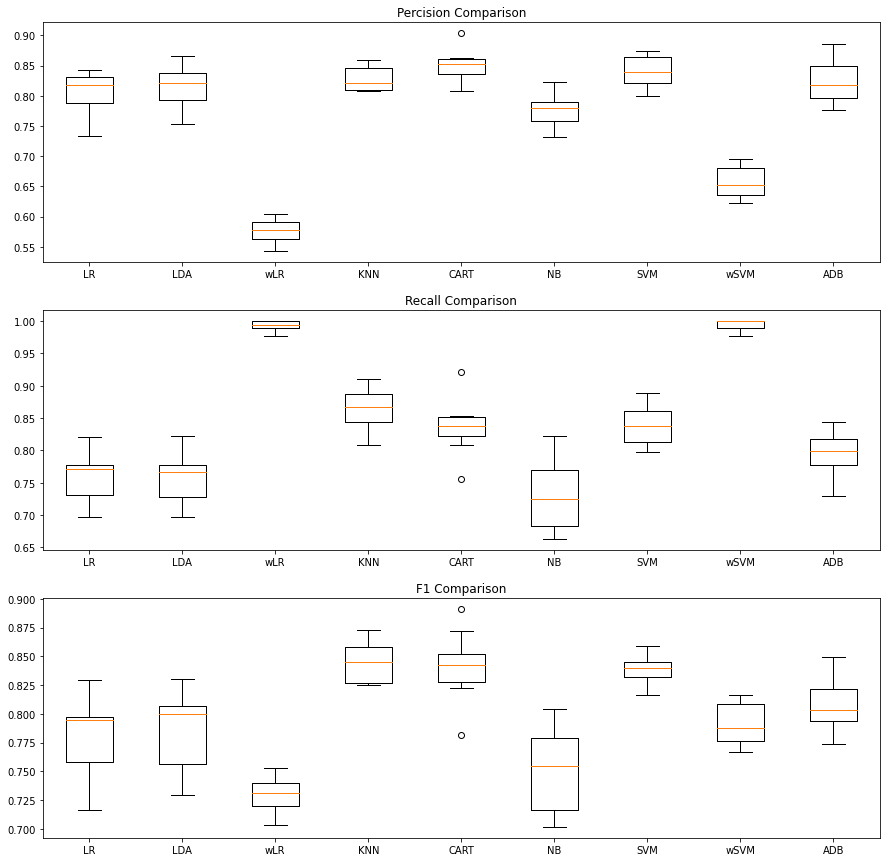

In [25]:
f = pyplot.figure(figsize=(15,15))
f.add_subplot(3, 1, 1)
pyplot.boxplot(Percision, labels=names)
pyplot.title('Percision Comparison')
f.add_subplot(3, 1, 2)
pyplot.boxplot(Recall, labels=names)
pyplot.title('Recall Comparison')
f.add_subplot(3, 1, 3)
pyplot.boxplot(F1, labels=names)
pyplot.title('F1 Comparison')
pyplot.show(block=True)

In [26]:
# Make predictions on validation dataset
model =  DecisionTreeClassifier()
model.fit(xb_train_res, yb_train_res)
predictions = model.predict(Xb_test)

# Evaluate predictions genetics
print(accuracy_score(yb_test, predictions))
print(confusion_matrix(yb_test, predictions))
print(classification_report(yb_test, predictions))

0.8894230769230769
[[361  34]
 [ 12   9]]
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       395
           1       0.21      0.43      0.28        21

    accuracy                           0.89       416
   macro avg       0.59      0.67      0.61       416
weighted avg       0.93      0.89      0.91       416



In [27]:
# evaluate each behavior and genetics together - precision sometimes equal 0
# wLR seems to look best
Percision = []
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Recall = cross_val_score(model, X_train, y_train, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1')
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s: Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR: Recall: 0.326786 (0.134356); f1: 0.436177 (0.180844)
LDA: Recall: 0.482143 (0.220447); f1: 0.493941 (0.207325)
wLR: Recall: 0.732143 (0.178928); f1: 0.430266 (0.099389)
KNN: Recall: 0.171429 (0.114118); f1: 0.241597 (0.162956)
CART: Recall: 0.260714 (0.196299); f1: 0.199113 (0.180815)
NB: Recall: 0.658929 (0.184102); f1: 0.438615 (0.136107)
SVM: Recall: 0.078571 (0.085341); f1: 0.128030 (0.133777)
wSVM: Recall: 0.608929 (0.126635); f1: 0.356146 (0.079261)
ADB: Recall: 0.280357 (0.132685); f1: 0.320403 (0.121142)


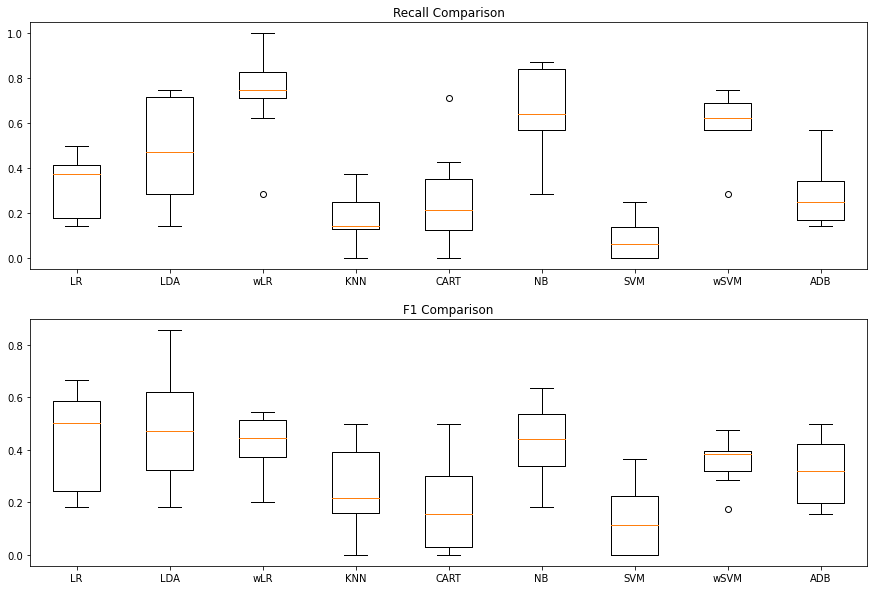

In [28]:
f = pyplot.figure(figsize=(15,10))
f.add_subplot(2, 1, 1)
pyplot.boxplot(Recall, labels=names)
pyplot.title('Recall Comparison')
f.add_subplot(2, 1, 2)
pyplot.boxplot(F1, labels=names)
pyplot.title('F1 Comparison')
pyplot.show(block=True)

In [29]:
#over sample PTSD
sm = SMOTE(random_state=12)
x_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [30]:
# evaluate the combained model GB?
Percision = []
Recall = []
F1 =[]
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
    cv_Percision = cross_val_score(model, x_train_res, y_train_res, cv=kfold, scoring='precision')
    cv_Recall = cross_val_score(model, x_train_res, y_train_res, cv=kfold, scoring='recall')
    cv_F1 = cross_val_score(model, x_train_res, y_train_res, cv=kfold, scoring='f1')
    Percision.append(cv_Percision)
    Recall.append(cv_Recall)
    F1.append(cv_F1)
    names.append(name)
    print('%s: Percision: %f (%f); Recall: %f (%f); f1: %f (%f)' % 
          (name, cv_Percision.mean(), cv_Percision.std(),
           cv_Recall.mean(), cv_Recall.std(),
          cv_F1.mean(), cv_F1.std()))

LR: Percision: 0.835818 (0.036707); Recall: 0.831286 (0.026587); f1: 0.832814 (0.020706)
LDA: Percision: 0.830777 (0.040863); Recall: 0.813421 (0.038631); f1: 0.821208 (0.030827)
wLR: Percision: 0.650530 (0.022076); Recall: 0.991061 (0.004470); f1: 0.785265 (0.016344)
KNN: Percision: 0.815926 (0.030121); Recall: 0.977615 (0.015882); f1: 0.889065 (0.018068)
CART: Percision: 0.885214 (0.034112); Recall: 0.938564 (0.013436); f1: 0.905789 (0.020777)
NB: Percision: 0.737223 (0.015383); Recall: 0.903958 (0.037933); f1: 0.811596 (0.016357)
SVM: Percision: 0.843565 (0.024364); Recall: 0.878240 (0.032499); f1: 0.859851 (0.015052)
wSVM: Percision: 0.710547 (0.035690); Recall: 0.995543 (0.007382); f1: 0.828700 (0.023836)
ADB: Percision: 0.908336 (0.026704); Recall: 0.919588 (0.019682); f1: 0.913520 (0.013730)


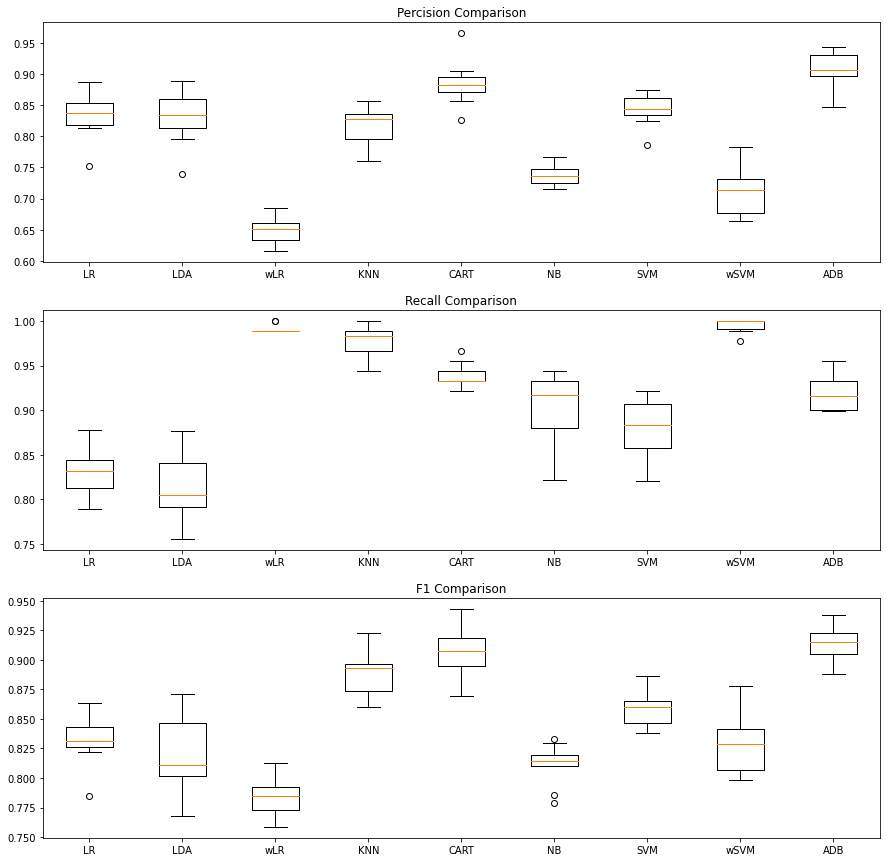

In [31]:
f = pyplot.figure(figsize=(15,15))
f.add_subplot(3, 1, 1)
pyplot.boxplot(Percision, labels=names)
pyplot.title('Percision Comparison')
f.add_subplot(3, 1, 2)
pyplot.boxplot(Recall, labels=names)
pyplot.title('Recall Comparison')
f.add_subplot(3, 1, 3)
pyplot.boxplot(F1, labels=names)
pyplot.title('F1 Comparison')
pyplot.show(block=True)

In [32]:
# Make predictions on validation dataset
model =  KNeighborsClassifier()
model.fit(x_train_res, y_train_res)
predictions = model.predict(X_test)

# Evaluate predictions
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.7716346153846154
[[305  90]
 [  5  16]]
              precision    recall  f1-score   support

           0       0.98      0.77      0.87       395
           1       0.15      0.76      0.25        21

    accuracy                           0.77       416
   macro avg       0.57      0.77      0.56       416
weighted avg       0.94      0.77      0.83       416



In [38]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]

#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()

#Use GridSearch
from sklearn.model_selection import GridSearchCV

model = GridSearchCV(knn_2, hyperparameters, cv=10)

#Fit the model
best_model = model.fit(x_train_res, y_train_res)

In [39]:
# Evaluate predictions
print(accuracy_score(y_test, predictions))
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))

0.8677884615384616
[[349  46]
 [  9  12]]
              precision    recall  f1-score   support

           0       0.97      0.88      0.93       395
           1       0.21      0.57      0.30        21

    accuracy                           0.87       416
   macro avg       0.59      0.73      0.62       416
weighted avg       0.94      0.87      0.90       416



In [44]:
# Generalizing to 2nd cohort
predictions = best_model.predict(pred_X)

# Evaluate predictions
print(accuracy_score(pred_y, predictions))
print(confusion_matrix(pred_y, predictions))
print(classification_report(pred_y, predictions))

0.8428290766208252
[[413  58]
 [ 22  16]]
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       471
           1       0.22      0.42      0.29        38

    accuracy                           0.84       509
   macro avg       0.58      0.65      0.60       509
weighted avg       0.89      0.84      0.86       509

